<a href="https://colab.research.google.com/github/walwaljj/colab/blob/main/main1104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

/
Mounted at /content/drive


In [2]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 604 kB 42.1 MB/s 
     |████████████████████████████████| 120 kB 46.0 MB/s 
     |████████████████████████████████| 47.6 MB 1.9 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [3]:
import easyocr
reader = easyocr.Reader(['ko'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      // const capture = document.createElement('button');
      // capture.textContent = 'Capture';
      // div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //자바스크립트 부분에서 위쪽에 주석 처리한 세 줄을 풀고
      //아래 코드 주석을 풀면 capture 버튼이 나옴 -> 수동으로 웹캠 캡쳐 가능
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [49]:
file_name = take_photo()
img_path = '/content/drive/MyDrive/yolov4_tiny/testimg/1.jpg'

<IPython.core.display.Javascript object>

클래스 번호:  0 
클래스: norm 
norm일 확률:  0.9862327575683594


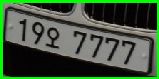


차량번호 앞자리:  19오 
차량번호 뒷자리:  7777


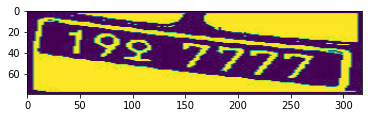

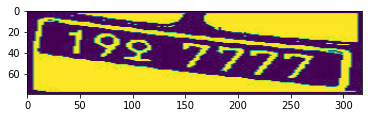

In [59]:
import cv2
from PIL import Image
import imutils
from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import re
import numpy as np


img = cv2.imread(img_path)

with open('/content/drive/MyDrive/yolov4_tiny/darknet/data/obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/yolov4_tiny/darknet/cfg/yolov4-tiny-custom.cfg', '/content/drive/MyDrive/yolov4_tiny/training/yolov4_tiny_test3/yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

clss = classIds.tolist()
score = scores.tolist()

# 주차딱지 변수 값 지정
# Object Detection 했을 때 주차딱지가 Detection 안 되면 class_num_y와 class_name_yellow 는 'x'값을 가짐
# 주차딱지가 Detection 되면 class_num_y는 '3', class_name_yellow 는 '주차딱지' 값을 가짐 (아래에 있는 if 문)

class_num_y = 'x'
class_name_yellow = 'x'

# # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

for i in range(len(clss)):
    box = boxes[i].tolist()
    w = box[0]
    h = box[1]
    x = box[2]
    y = box[3]
    bbox = img[h:y+h, w:x+w]



    if clss[i] == 0:
        print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])
        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        cv2_imshow(bbox)
        cv2.imwrite('norm.jpg', bbox) #저장

        if bbox is None:
            print('Image load failed!')
            bbox.exit()

        src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

				# 설정한 검은색의 rgb 범위 (0, 0, 0) ~ (80, 80, 80)
        dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
        cv2.imwrite('norm_black.jpg', dst1)

        norm_black = Image.open('norm_black.jpg')

				# 가로 세로 길이 조절
        norm_black = norm_black.resize((int(norm_black.width), int(norm_black.height)))
        norm_black.save('norm_black.jpg')
        norm_black = Image.open('norm_black.jpg')

				# ------------ OCR
        result = reader.readtext(norm_black)

				#result에서 00가0000 형태인지 찾기
        for a in result:
          if re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            class_num = str(clss[i])
            class_name = '일반'
          elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            norm_re = norm_black.resize((int(norm_black.width*2), int(norm_black.height)))         
            plt.figure()
            plt.imshow(norm_re)
            norm_re.save('norm_re.jpg',)
            norm_re=Image.open('norm_re.jpg')
            result = reader.readtext(norm_re)


    elif clss[i] == 1:
        print('클래스 번호: ', clss[i], '\n클래스: elec', '\nelec일 확률: ', score[i])
        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        cv2_imshow(bbox)
        cv2.imwrite('elec.jpg', bbox)

        if bbox is None:
            print('Image load failed!')
            bbox.exit()

        src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

        dst1 = cv2.inRange(bbox, (0, 0, 0), (70, 80, 80))
        cv2.imwrite('elec_black.jpg', dst1)
        elec_black = Image.open('elec_black.jpg')

				# 가로 세로 길이 조절
        elec_black = elec_black.resize((int(elec_black.width), int(elec_black.height)))
        elec_black.save('elec_black.jpg')
        elec_black = Image.open('elec_black.jpg')

				# ------------ OCR
        result = reader.readtext(elec_black)
        #result에서 00가0000 형태인지 찾기
        for a in result:
          if re.match(r'[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            class_num = str(clss[i])
            class_name = '전기'
          elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            elec_re = elec_black.resize((int(elec_black.width*2), int(elec_black.height)))
            plt.figure()
            elec_re.save('elec_re.jpg',)
            elec_re=Image.open('elec_re.jpg')
            result = reader.readtext(elec_re)

    if clss[i] == 3:
        print('클래스 번호: ', clss[i], '\n클래스: yellow', '\nyellow일 확률: ', score[i])
        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        cv2_imshow(bbox)
        class_num_y = str(clss[i])
        class_name_yellow = '주차딱지'


# -------------------한글 & 숫자 추출함수-------------------
def result_plate():
  result_list = []

  # 번호판으로 올 수 있는 문자만 추출 하기 위함.
  plate = ['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '버', '서', '어', '저', '고', '노', '도', '로', '모', '보', '소', '오', '조', '구', '누', '두', '루', '무', '부', '수', '우', '주', '허', '하', '호', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  first_num = ''
  second_num = ''
  str_cnt = 0 # 앞 번호판의 문자 (1글자)만 읽기 위함.

  for i in result :
    for j in i[1] :
      for str in plate :
          if j == str :
            result_list.append(j)
            
            # 문자를 기준으로 앞번호 , 뒷 번호를 슬라이싱.
            if '가'<=j<='힣' and str_cnt == 0 : 
              str_cnt += 1
              first_num=result_list[:result_list.index(j)+1]
              second_num=result_list[result_list.index(j)+1:] 
              
              # 형식에 맞게 들어왔는지 체크.
              if 3<=len(first_num)<=4 :
                first_num = ''.join(first_num)
              else :
                first_num = 'error'

            # 앞 번호 문자 추출이후 뒷 번호를 한번 더 체크
            else :
               # 번호판 앞 번호와 뒷 번호가 분리되어 result로 들어온 경우. ex)'101하' , '4609'
                if re.match(r'{}\$'.format(first_num) , i[1]) : 
                  result_list2 = [n for n in result_list if '0'<=n<='9' not in result_list] 
                  second_num = ''.join(result_list2[-4:])
                
                # 번호판 뒷 번호에 필요없는 문자가 섞여있는 경우 ex)'107rㄱㄱ1 6540가00'
                elif re.search('[가-힣]',''.join(result_list[-4:])):
                    result_list2 = re.sub('[가-힣]','',''.join(result_list[:])) 
                    second_num = ''.join(result_list2[-4:])

                # 번호판 앞 번호와 뒷 번호가 분리되지 않고 result로 들어온 경우. ex) '101하 4609'
                else :
                    result_list2 = [n for n in result_list if '0'<=n<='9' in result_list] 
                    second_num = ''.join(result_list2[-4:])

  return first_num,second_num
first_num , second_num = result_plate()

print(#'클래스 번호:', class_num,
      # '\n클래스 이름: ', class_name,
      '\n차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)